In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt


In [4]:
import sys
sys.executable

'C:\\Users\\mchikda2\\AppData\\Local\\Programs\\Python\\Python39\\python.exe'

In [5]:
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 96
plt.rcParams['savefig.dpi'] = 240

In [6]:
FILENAMES = 'StepsTestV2_2021-01-15_*.csv'
PWM_MIN, PWM_MAX = 1000, 2000
PWM_MASK_MIN, PWM_MASK_MAX = 1000, 2000

In [7]:
def read_file(fname):
    rcb = pd.read_csv(fname, index_col='Time (s)')
    rcb.index = pd.TimedeltaIndex(rcb.index, unit='s')
    return rcb

def thrust_model_func(pwm, α, k):
    pwm_rel = (pwm - PWM_MIN) / (PWM_MAX - PWM_MIN)
    return α * (k * pwm_rel**2 + (1-k) * pwm_rel)

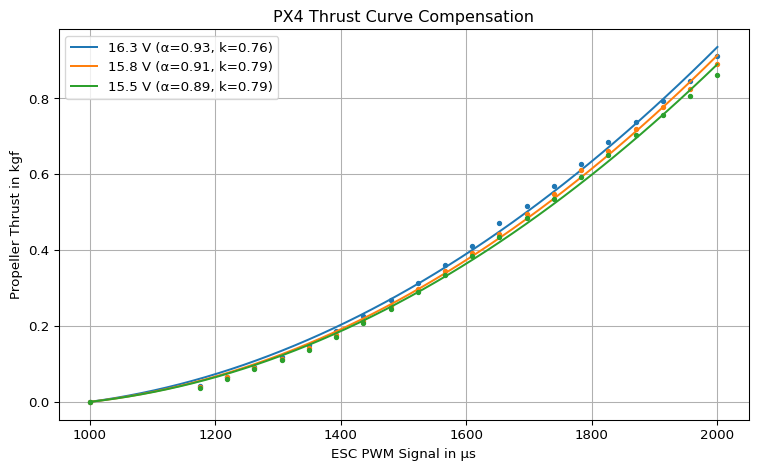

In [8]:
fig, ax = plt.subplots()
pwm_space = np.linspace(PWM_MASK_MIN, PWM_MASK_MAX)

for i, fname in enumerate(sorted(Path().glob(FILENAMES))):
    rcb = read_file(fname)

    V = rcb.loc[rcb['Motor Electrical Speed (rad/s)']/0.104719755 < 10, 'Voltage (V)'].mean()
    pwm = rcb['ESC signal (µs)']
    thrust = rcb['Thrust (kgf)']
    mask = (pwm >= PWM_MASK_MIN) & (pwm <= PWM_MASK_MAX)

    (α, k), _ = optimize.curve_fit(thrust_model_func, pwm[mask], thrust[mask])
    thrust_model = partial(thrust_model_func, α=α, k=k)
    
    c = f'C{i}'

    ax.plot(pwm, thrust, '.', color=c)
    ax.plot(pwm_space, thrust_model(pwm_space), '-', color=c, label=f"{V:.1f} V (α={α:.2f}, k={k:.2f})")

ax.set_xlabel("ESC PWM Signal in µs")
ax.set_ylabel("Propeller Thrust in kgf")

ax.set_title("PX4 Thrust Curve Compensation")
ax.legend()
fig.tight_layout()
fig.savefig("px4-thrust-curve-compensation")
            